In [1]:
!pip install pydrive

In [2]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
%matplotlib inline

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
downloaded = drive.CreateFile({'id':"1oYLlTEjUEsdJmLlEPlJuHSavgfXK2B2g"})   # replace the id with id of file you want to access
downloaded.GetContentFile('Recording.wav')        # replace the file name with your file

In [5]:

ipd.Audio( "Recording.wav")


In [6]:
sample_rate, audio = wavfile.read( "Recording.wav")
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 44100Hz
Audio duration: 3.4133333333333336s


In [7]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

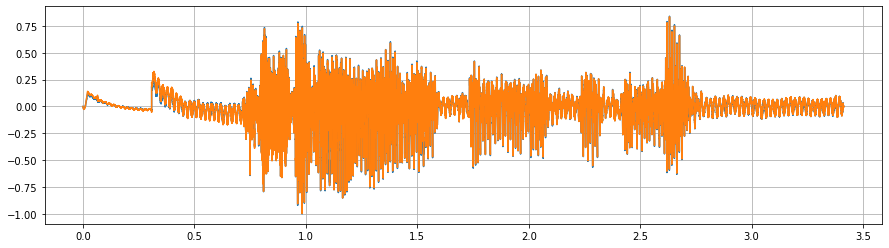

In [8]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)


In [9]:
audio.flatten()


array([-0.00010883, -0.00010883, -0.00032648, ..., -0.0004353 ,
        0.00217652, -0.00185004])

In [35]:

def framing(sig, fs=44100, win_len=0.015, win_hop=0.015):
     """
     transform a signal into a series of overlapping frames.

     Args:
         sig            (array) : a mono audio signal (Nx1) from which to compute features.
         fs               (int) : the sampling frequency of the signal we are working with.
                                  Default is 16000.
         win_len        (float) : window length in sec.
                                  Default is 0.025.
         win_hop        (float) : step between successive windows in sec.
                                  Default is 0.01.

     Returns:
         array of frames.
         frame length.
     """
     # compute frame length and frame step (convert from seconds to samples)
     frame_length = win_len * fs
     frame_step = win_hop * fs
     signal_length = len(sig)
     frames_overlap = frame_length - frame_step

     # Make sure that we have at least 1 frame+
     num_frames = np.abs(signal_length - frames_overlap) // np.abs(frame_length - frames_overlap)
     rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)

     # Pad Signal to make sure that all frames have equal number of samples
     # without truncating any samples from the original signal
     if rest_samples != 0:
         pad_signal_length = int(frame_step - rest_samples)
         z = np.zeros((pad_signal_length))
         pad_signal = np.append(sig, z)
         num_frames += 1
     else:
         pad_signal = sig

     # make sure to use integers as indices
     frame_length = int(frame_length)
     frame_step = int(frame_step)
     num_frames = int(num_frames)

     # compute indices
     idx1 = np.tile(np.arange(0, frame_length), (num_frames, 1))
     idx2 = np.tile(np.arange(0, num_frames * frame_step, frame_step),
                    (frame_length, 1)).T
     indices = idx1 + idx2
     frames = pad_signal[indices.astype(np.int32, copy=False)]
     return frames

In [36]:

FFT_size=661
audio_framed = framing(audio)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (228, 661)


In [37]:
print("First frame:")
audio_framed[1]

First frame:


array([-0.02187398, -0.01904451, -0.02198281, -0.01915334, -0.02176515,
       -0.01871803, -0.02165633, -0.01871803, -0.02165633, -0.01871803,
       -0.02143868, -0.01860921, -0.02143868, -0.01882686, -0.0211122 ,
       -0.01850038, -0.02122103, -0.01839156, -0.02132985, -0.01839156,
       -0.0211122 , -0.0181739 , -0.02089455, -0.01795625, -0.0206769 ,
       -0.01795625, -0.0206769 , -0.01795625, -0.02078572, -0.01784743,
       -0.02056807, -0.01752095, -0.02035042, -0.0177386 , -0.02024159,
       -0.01762977, -0.02002394, -0.01708565, -0.02002394, -0.01708565,
       -0.01969746, -0.01741212, -0.01958864, -0.01719447, -0.02002394,
       -0.01686799, -0.01958864, -0.01675917, -0.01937099, -0.01654152,
       -0.01904451, -0.01654152, -0.01904451, -0.01665034, -0.01893568,
       -0.01654152, -0.01882686, -0.01643269, -0.01893568, -0.01610621,
       -0.01882686, -0.01577974, -0.01860921, -0.01610621, -0.01860921,
       -0.01567091, -0.01839156, -0.01567091, -0.0181739 , -0.01

In [38]:
print("Last frame:")
audio_framed[-1]

Last frame:


array([ 0.01512678,  0.0177386 ,  0.01120905,  0.01762977,  0.01120905,
        0.01599739,  0.01643269,  0.02481228,  0.01991512,  0.02949178,
        0.02720644,  0.03710959,  0.03155947,  0.04059201,  0.03819785,
        0.04592447,  0.04342148,  0.05582762,  0.05735118,  0.06431603,
        0.06224834,  0.06279247,  0.05756883,  0.06398955,  0.05767766,
        0.06877789,  0.06551311,  0.07508978,  0.0747633 ,  0.07171618,
        0.06779845,  0.06583959,  0.06213951,  0.07236914,  0.06812493,
        0.08793122,  0.07933399,  0.0819458 ,  0.07998694,  0.07443683,
        0.0709544 ,  0.07791925,  0.07519861,  0.091196  ,  0.08357819,
        0.08891065,  0.08074872,  0.08161933,  0.07421918,  0.06834258,
        0.06159539,  0.06551311,  0.0637719 ,  0.07356622,  0.07019262,
        0.06518664,  0.06116008,  0.05049516,  0.04657743,  0.04407444,
        0.04429209,  0.05386876,  0.05082163,  0.04886277,  0.04831864,
        0.03917728,  0.03482425,  0.03645663,  0.02862118,  0.03

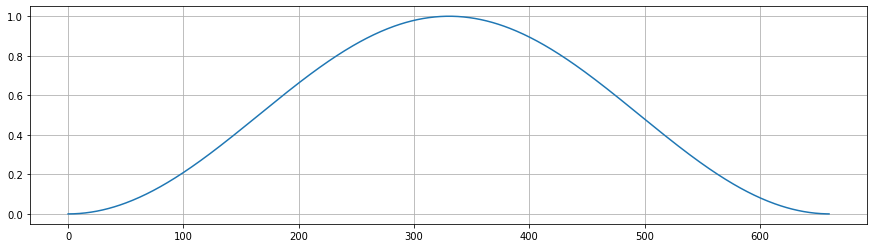

In [16]:
window = get_window("hann", 661, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

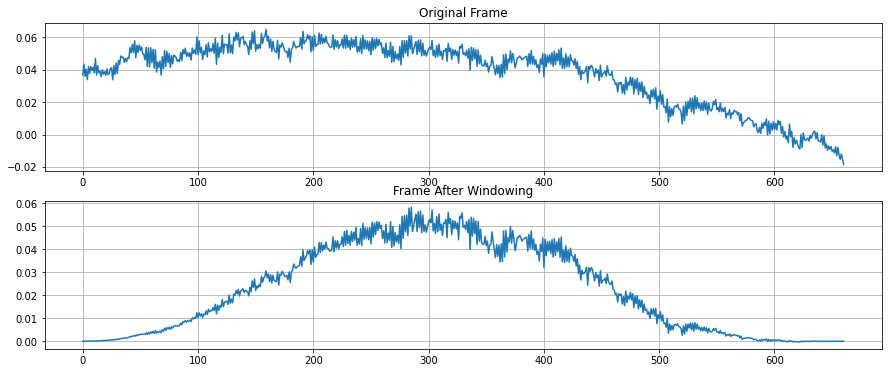

In [17]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [19]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + 661 // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [20]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(228, 331)


In [21]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

Minimum frequency: 0
Maximum frequency: 22050.0


In [22]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [23]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [24]:
filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

MEL min: 0.0
MEL max: 3923.337321740179


array([  0,   3,   9,  16,  26,  40,  59,  85, 121, 170, 238, 331])

In [25]:
def get_filters(filter_points):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

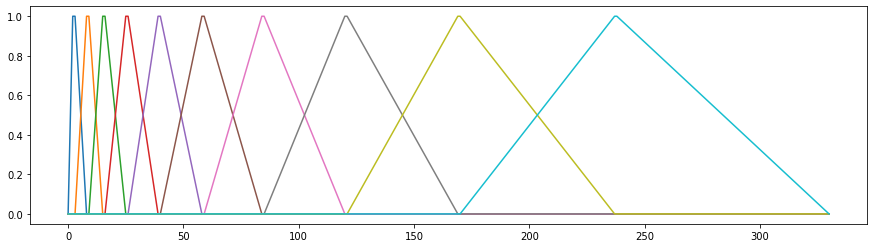

In [26]:
filters = get_filters(filter_points)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [27]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

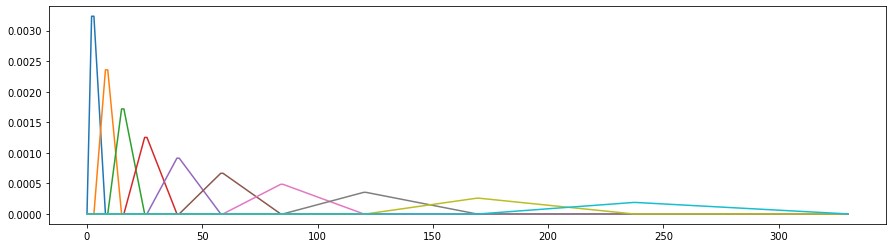

In [28]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [29]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 228)

In [30]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [31]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 228)

In [32]:
cepstral_coefficents[:, 0]

array([-2.17743149e+02,  3.36670718e+01,  3.14541263e+01,  2.26695776e+01,
        2.00052311e+01,  1.12595159e+01,  1.21574799e+01,  5.62855869e+00,
        4.83026615e+00,  1.61521882e+00,  3.24211135e-13, -1.61521882e+00,
       -4.83026615e+00, -5.62855869e+00, -1.21574799e+01, -1.12595159e+01,
       -2.00052311e+01, -2.26695776e+01, -3.14541263e+01, -3.36670718e+01,
        3.07935314e+02, -3.36670718e+01, -3.14541263e+01, -2.26695776e+01,
       -2.00052311e+01, -1.12595159e+01, -1.21574799e+01, -5.62855869e+00,
       -4.83026615e+00, -1.61521882e+00, -5.04022500e-14,  1.61521882e+00,
        4.83026615e+00,  5.62855869e+00,  1.21574799e+01,  1.12595159e+01,
        2.00052311e+01,  2.26695776e+01,  3.14541263e+01,  3.36670718e+01])

Text(0, 0.5, 'MFCC Coefficients')

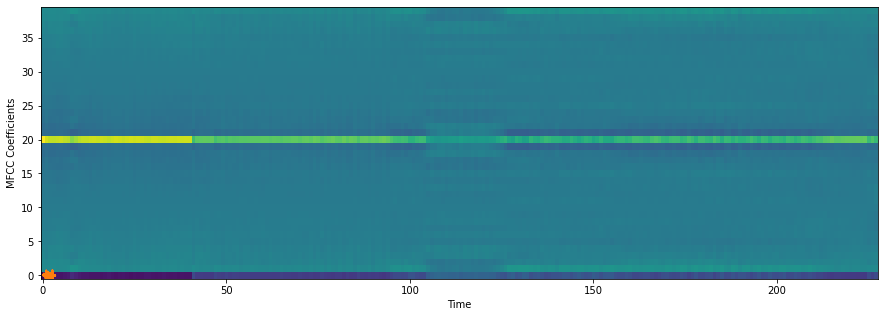

In [34]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')